### Library Import

In [91]:
import pandas as pd
import numpy as np
import os

from models.utility import load_input, scale_with_minmax, get_dates_from_config, handle_outliers, \
    get_params_from_config, dailydf_to_ts, inverse_transform_minmax, transform_dayofyear, write_DWH
from models.lstm import simpleLSTM
from models.deeplearner import DeepLearner

from solutil import evaluations

### Input Preparation

In [92]:
# Define global variables
str_model = 'inlet2_lstm'

In [93]:
# Load Input Parameters
dates = get_dates_from_config(str_model)
df_variables = load_input(str_model=str_model, **dates)

base
base_1d
useday_1d
temp_1h
glob_1h
rain_1h
bf15_1h
schmelz_1h


In [94]:
df_variables

,base_lag0,base_1d_lag0,temp_1h_lag0,temp_1h_lag1,glob_1h_lag1,glob_1h_lag2,glob_1h_lag3,rain_1h_lag0,rain_1h_lag1,bf15_1h_lag0,schmelz_1h_lag0,schmelz_1h_lag1
2021-03-02 00:00:00+01:00,1.265927,1.192465,3.485418,3.056250,0.000000,67.564583,471.766667,0.000000,0.000000,1.126800,0.056250,0.054175
2021-03-02 04:00:00+01:00,1.092410,1.192465,3.687498,3.485418,0.000000,0.000000,67.564583,0.000000,0.000000,1.123125,0.068350,0.056250
2021-03-02 08:00:00+01:00,1.035635,1.192465,6.229167,3.687498,7.622917,0.000000,0.000000,0.000000,0.000000,1.124425,0.086225,0.068350
2021-03-02 12:00:00+01:00,1.134340,1.192465,10.293768,6.229167,372.379167,7.622917,0.000000,0.000000,0.000000,1.112425,0.097900,0.086225
2021-03-02 16:00:00+01:00,1.405728,1.192465,7.958333,10.293768,492.562500,372.379167,7.622917,0.000000,0.000000,1.103950,0.080825,0.097900
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-07 08:00:00+01:00,4.300000,4.300000,9.954167,9.995833,16.108333,0.095833,0.121875,0.135833,0.025000,1.134438,0.000000,0.000000
2024-07-07 12:00:00+01:00,4.300000,4.300000,12.208333,9.954167,174.204167,16.108333,0.095833,0.022500,0.135833,1.116833,0.000000,0.000000
2024-07-07 16:00:00+01:00,4.300000,4.300000,13.347917,12.208333,320.371875,174.204167,16.108333,0.000000,0.022500,1.106021,0.000000,0.000000
2024-07-07 20:00:00+01:00,4.300000,4.300000,12.137500,13.347917,79.783333,320.371875,174.204167,0.050000,0.000000,1.100292,0.000000,0.000000


In [95]:
df_doy = transform_dayofyear(df_variables)

There are some outliers in the data, as can be seen from the following plot.

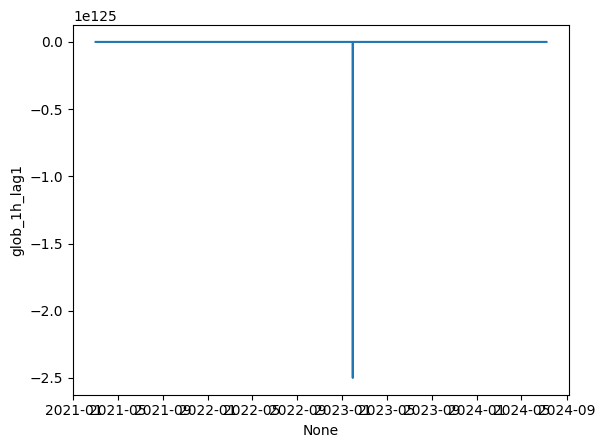

In [96]:
import seaborn as sns

fig = sns.lineplot(x=df_variables.index, y=df_doy['glob_1h_lag1'])

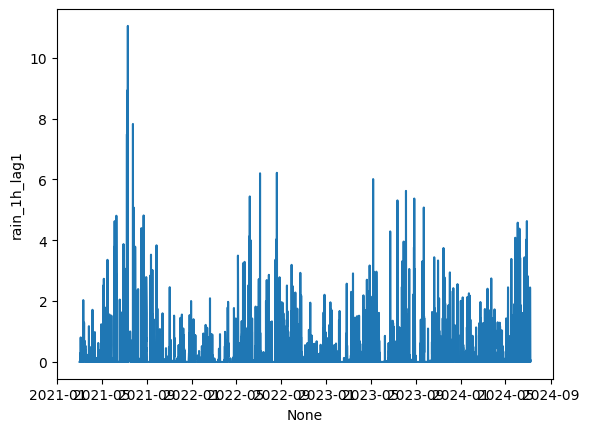

In [97]:
fig = sns.lineplot(x=df_variables.index, y=df_variables['rain_1h_lag1'])

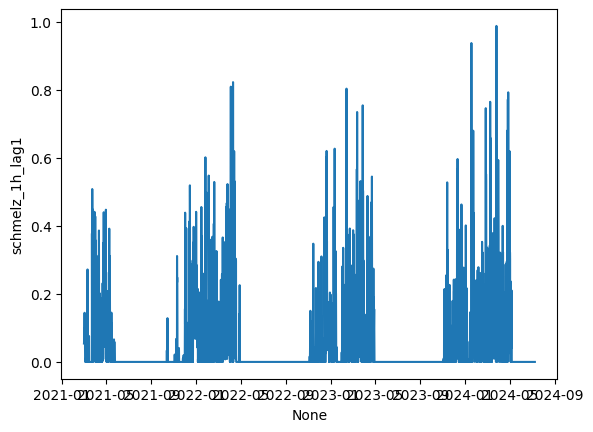

In [98]:
fig = sns.lineplot(x=df_variables.index, y=df_variables['schmelz_1h_lag1'])

In [99]:
# Handle outliers
df_handled = handle_outliers(df_doy)

Variable base_lag0
Variable base_1d_lag0
Variable temp_1h_lag0
Variable temp_1h_lag1
Variable glob_1h_lag1
Variable glob_1h_lag2
Variable glob_1h_lag3
Variable rain_1h_lag0
Variable rain_1h_lag1
Variable bf15_1h_lag0
Variable schmelz_1h_lag0
Variable schmelz_1h_lag1
Variable yearday_sin
Variable yearday_cos


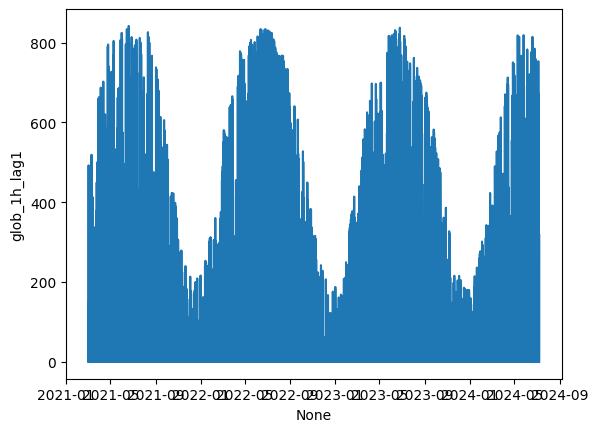

In [100]:
fig = sns.lineplot(x=df_handled.index, y=df_handled['glob_1h_lag1'])

In [101]:
# Scale inputs
df_scaled = scale_with_minmax(df_handled, str_model, verbose=0)

In [102]:
# Initialize lstm class
lstm = simpleLSTM()
deepl = DeepLearner()

In [103]:
# Generate sequences
n_lookback = 20
n_ahead = 6
n_offset = 0
target_var = 'base_lag0'

df_seq = lstm.generate_sequences(df_scaled, target_var, n_lookback, n_ahead, n_offset, continuous=False)

Length df_x: 7225 - length df_y: 7225


In [104]:
lstm.ytest_startdate

Timestamp('2023-07-13 08:00:00+0100', tz='Etc/GMT-1')

In [133]:
df_scaled.iloc[5050:5060]

,base_lag0,base_1d_lag0,temp_1h_lag0,temp_1h_lag1,glob_1h_lag1,glob_1h_lag2,glob_1h_lag3,rain_1h_lag0,rain_1h_lag1,bf15_1h_lag0,schmelz_1h_lag0,schmelz_1h_lag1,yearday_sin,yearday_cos
2023-07-11 16:00:00+01:00,0.000000,0.016852,0.876559,0.880043,0.923249,0.938210,0.276033,0.000000,0.000000,0.308119,0.0,0.0,0.412940,0.007638
2023-07-11 20:00:00+01:00,0.034367,0.016852,0.821169,0.876559,0.254827,0.923249,0.943341,0.102495,0.000000,0.379614,0.0,0.0,0.411528,0.007889
2023-07-12 00:00:00+01:00,0.026092,0.016852,0.784100,0.821169,0.000307,0.254827,0.928298,0.013704,0.102495,0.419694,0.0,0.0,0.410116,0.008145
2023-07-12 04:00:00+01:00,0.025378,0.016852,0.738038,0.784100,0.000949,0.000307,0.256221,0.346463,0.013704,0.425878,0.0,0.0,0.408706,0.008405
2023-07-12 08:00:00+01:00,0.143594,0.016852,0.803125,0.738038,0.056750,0.000949,0.000309,0.072624,0.346463,0.414072,0.0,0.0,0.407296,0.008669
2023-07-12 12:00:00+01:00,0.111855,0.016852,0.777586,0.803125,0.537544,0.056750,0.000954,0.163959,0.072624,0.428697,0.0,0.0,0.405886,0.008937
2023-07-12 16:00:00+01:00,0.276162,0.016852,0.727257,0.777586,0.311251,0.537544,0.057061,0.139786,0.163959,0.540033,0.0,0.0,0.404478,0.009209
2023-07-12 20:00:00+01:00,1.000000,0.016852,0.673123,0.727257,0.066956,0.311251,0.540483,0.367389,0.139786,0.645986,0.0,0.0,0.403070,0.009485
2023-07-13 00:00:00+01:00,1.000000,0.016852,0.644471,0.673123,0.000030,0.066956,0.312953,0.001067,0.367389,0.614539,0.0,0.0,0.401663,0.009765
2023-07-13 04:00:00+01:00,0.992353,0.016852,0.636227,0.644471,0.000187,0.000030,0.067322,0.098966,0.220776,0.582196,0.0,0.0,0.400257,0.010050


In [105]:
# Save variables
x_train = df_seq[0]
x_test = df_seq[1]
y_train = df_seq[2]
y_test = df_seq[3]

In [106]:
x_train.shape

(840, 20, 13)

### Model Initiation & Training

#### Grid Search

In [107]:
# Grid Search hyperparameters
hyperparams = {
    'units_l1': [100, 200],
    'units_l2': [100, 200],
    'dropout_l1': [0.1, 0.2],
    'dropout_l2': [0.1, 0.2],
    'activation_l1': ["sigmoid", "tanh"],
    'activation_l2': ['sigmoid', 'tanh']
}

lookback_periods = [20]

lookback_dict = deepl.get_grid_train_dict(lookback_periods, df_scaled, target_var) # kwargs possible

Length df_x: 7225 - length df_y: 7225


In [108]:
#results, best_model = deepl.grid_search_lstm(lookback_dict, hyperparams)

In [109]:
#results.to_csv('experiments/inlet2_lstm_gridsearch.csv')

The optimum model is configured with the option 55, representing the following specifics: 

{'units_l2': 200,
 'units_l1': 200,
 'dropout_l2': 0.2,
 'dropout_l1': 0.1,
 'activation_l2': 'tanh',
 'activation_l1': 'tanh'}

 However, the old configuration of the inlet1_lstm model is kept to simplify the model overview since the performance difference between the optimal configuration (55) and the inlet1 configuration (53) is negligible in terms of MSE, while the inlet1 config even performs better during validation. 

In [110]:
# Retrieve optimal model parameters
from sklearn.model_selection import ParameterGrid
option_grid = ParameterGrid(hyperparams)
opt_config = option_grid[53]

In [111]:
lstm_2l = lstm.build_2layer_lstm(x_train, y_train, **opt_config) # lstm.build_2layer_bidirectional_lstm(x_train, y_train, **opt_config)

Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_260 (LSTM)                      │ (None, 20, 100)             │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_260 (Dropout)                │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_261 (LSTM)                      │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_261 (Dropout)                │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_130 (Dense)                    │ (None, 6)                   │           1,206 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 287,606 (1.10 MB)

 Trainable params: 287,606 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

None


#### Train Final Model

In [112]:
# Get training parameters
train_params = get_params_from_config(function='model_train', str_model='inlet2_lstm')

In [113]:
# Train Model
trained_lstm, lstm_hist = deepl.train_model(x_train, y_train, lstm_2l, **train_params, verbose_int=1)

Epoch 1/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0952 - val_loss: 0.0651 - learning_rate: 0.0010
Epoch 2/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0595 - val_loss: 0.0536 - learning_rate: 0.0010
Epoch 3/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0503 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 4/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0475 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 5/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0457 - val_loss: 0.0331 - learning_rate: 0.0010
Epoch 6/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0383 - val_loss: 0.0245 - learning_rate: 0.0010
Epoch 7/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0349 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 8/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0336 - val_loss: 0.0235 - learning_rate: 0.0010
Epoch 9/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0279 - val_loss: 0.0211 - learning_rate: 0.0010
E

In [114]:
y_pred = trained_lstm.predict(x_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


### Model Evaluation

In [115]:
# Rescale predictions
y_pred = inverse_transform_minmax(y_pred, 'inlet2_lstm', ['base_lag0'])
y_test = inverse_transform_minmax(y_test, 'inlet2_lstm', ['base_lag0']) 

In [116]:
# Convert prediction to df
start_date = None #'01.01.2024 00:00:00'
n_timestep = None # 1

df_ypred = lstm.convert_seq_to_df(y_pred, n_timestep=n_timestep, start_date=start_date)

In [117]:
# Convert test seq to df
df_ytest = lstm.convert_seq_to_df(y_test, start_date=start_date, n_timestep=n_timestep)

In [118]:
# Convert df to time series
ts_ypred = dailydf_to_ts(df_ypred)
ts_ytest = dailydf_to_ts(df_ytest)

In [131]:
ts_ytest

2023-07-13 08:00:00+01:00    2.631382
2023-07-13 12:00:00+01:00    1.733526
2023-07-13 16:00:00+01:00    1.394692
2023-07-13 20:00:00+01:00    1.163135
2023-07-14 00:00:00+01:00    0.670192
                               ...   
2024-07-06 12:00:00+01:00    2.448039
2024-07-06 16:00:00+01:00    3.191885
2024-07-06 20:00:00+01:00    4.300000
2024-07-07 00:00:00+01:00    4.300000
2024-07-07 04:00:00+01:00    4.300000
Freq: 4h, Name: actual, Length: 2160, dtype: float64

In [119]:
# Calculate metrics
evaluations.get_eval_metrics(ts_ytest, ts_ypred)

{'mae': 0.42902921568376134,
 'mse': 0.4392339668231597,
 'rmse': 0.6627472872997366,
 'mape': 149188567499723.56,
 'non-na%': 1.0,
 'n_actual_obs': 2160,
 'n_pred_nas': 0}

<Axes: xlabel='time', ylabel='value'>

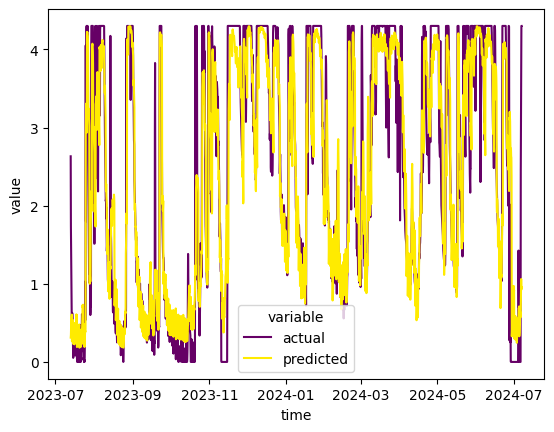

In [120]:
evaluations.get_act_vs_pred_plot(ts_ytest, ts_ypred)

### Save Model Output for Ensemble

In [121]:

data_dict = {'ypred_lstm': ts_ypred,
            'ytest': ts_ytest}

df_data = pd.DataFrame(data_dict)

#df_data.to_csv('experiments/stacking_data/ypred_lstm.csv')


In [122]:
#df_variables.to_csv('experiments/stacking_data/features_lstm.csv')

### Save Model Output for Ensemble

In [123]:
# Interpolate to 1h frequency
ts_ypred_1h = ts_ypred.resample('1h').interpolate()
df_ypred_1h = ts_ypred_1h.to_frame()

In [124]:
# Create ts name string
inlet_n = str_model.split('_')[0].capitalize()
str_algo = str_model.split('_')[1].upper()
str_pred = 'Prediction'
ts_name = '_'.join([inlet_n, str_pred, str_algo])

In [125]:
ts_name

'Inlet2_Prediction_LSTM'

In [126]:
# Save as csv
'''
write_DWH(str_path=os.path.join(r'\\srvedm11', 'Import', 'Messdaten', 'EPAG_Energie', 'DWH_EX_60'),
          str_tsname=ts_name,
          str_property="Python",
          str_unit='m/3',
          df_timeseries = df_ypred_1h
          )
'''

'\nwrite_DWH(str_path=os.path.join(r\'\\srvedm11\', \'Import\', \'Messdaten\', \'EPAG_Energie\', \'DWH_EX_60\'),\n          str_tsname=ts_name,\n          str_property="Python",\n          str_unit=\'m/3\',\n          df_timeseries = df_ypred_1h\n          )\n'

In [127]:
ts_ypred

2023-07-13 08:00:00+01:00    0.311385
2023-07-13 12:00:00+01:00    0.346312
2023-07-13 16:00:00+01:00    0.451916
2023-07-13 20:00:00+01:00    0.569283
2023-07-14 00:00:00+01:00    0.572311
                               ...   
2024-07-06 12:00:00+01:00    0.693797
2024-07-06 16:00:00+01:00    0.936210
2024-07-06 20:00:00+01:00    1.060752
2024-07-07 00:00:00+01:00    0.927016
2024-07-07 04:00:00+01:00    0.959249
Freq: 4h, Name: value, Length: 2160, dtype: float64